In [ ]:
#--------------------Bibliotecas necessárias
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from transformers import pipeline
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\clara\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#--------------------Coleta de dados
df_info = pd.read_csv(r'product_info.csv')
df_reviews1 = pd.read_csv(r'reviews_0-250.csv')
df_reviews2 = pd.read_csv(r'reviews_250-500.csv')
df_reviews3 = pd.read_csv(r'reviews_500-750.csv')
df_reviews4 = pd.read_csv(r'reviews_750-1250.csv')
df_reviews5 = pd.read_csv(r'reviews_1250-end.csv')

C:\Users\clara\AppData\Local\Temp\ipykernel_16780\396753492.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews1 = pd.read_csv(r'reviews_0-250.csv')
C:\Users\clara\AppData\Local\Temp\ipykernel_16780\396753492.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews4 = pd.read_csv(r'reviews_750-1250.csv')
C:\Users\clara\AppData\Local\Temp\ipykernel_16780\396753492.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews5 = pd.read_csv(r'reviews_1250-end.csv')


In [3]:
#--------------------Entendimento do dados
print('Primeiras informações dos dataframes:')
print('Head df_info:')    
print(df_info.head())
print('\nHead df_reviews1:')
print(df_reviews1.head())

print('\nInfo df_info:')
print(df_info.info())
print('\nInfo df_reviews1:')
print(df_reviews1.info())

print('\nDescriptive statistics df_info:')
print(df_info.describe())
print('\nDescriptive statistics df_reviews1:')
print(df_reviews1.describe())

print('\nValores únicos por coluna:')
print('df_info:')
print(df_info.nunique())
print('\ndf_reviews1:')
print(df_reviews1.nunique())
print('\ndf_reviews2:')
print(df_reviews2.nunique())
print('\ndf_reviews3:')
print(df_reviews3.nunique())
print('\ndf_reviews4:')
print(df_reviews4.nunique())
print('\ndf_reviews5:')
print(df_reviews5.nunique())

print('\nValores nulos por coluna:')
print('df_info:')
print(df_info.isnull().sum())
print('\ndf_reviews1:')
print(df_reviews1.isnull().sum())
print('\ndf_reviews2:')
print(df_reviews2.isnull().sum())
print('\ndf_reviews3:')
print(df_reviews3.isnull().sum())
print('\ndf_reviews4:')
print(df_reviews4.isnull().sum())
print('\ndf_reviews5:')
print(df_reviews5.isnull().sum())

print('\nValores duplicados por coluna:')
print('\ndf_info:')
print(df_info.duplicated().sum())
print('\ndf_reviews1:')
print(df_reviews1.duplicated().sum())
print('\ndf_reviews2:')
print(df_reviews2.duplicated().sum())
print('\ndf_reviews3:')
print(df_reviews3.duplicated().sum())
print('\ndf_reviews4:')
print(df_reviews4.duplicated().sum())
print('\ndf_reviews5:')
print(df_reviews5.duplicated().sum())


Primeiras informações dos dataframes:
Head df_info:
  product_id               product_name  brand_id brand_name  loves_count  \
0    P473671    Fragrance Discovery Set      6342      19-69         6320   
1    P473668    La Habana Eau de Parfum      6342      19-69         3827   
2    P473662  Rainbow Bar Eau de Parfum      6342      19-69         3253   
3    P473660       Kasbah Eau de Parfum      6342      19-69         3018   
4    P473658  Purple Haze Eau de Parfum      6342      19-69         2691   

   rating  reviews            size                      variation_type  \
0  3.6364     11.0             NaN                                 NaN   
1  4.1538     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
2  4.2500     16.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
3  4.4762     21.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
4  3.2308     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   

  variation_value  ... online_only out_o

In [70]:
#--------------------Limpeza e pré-processamento
# limpeza dos dados
df_info.dropna(subset=['rating', 'reviews'], inplace=True)

def clean_reviews(df):
    df = df.dropna(subset=['review_text', 'is_recommended', 'helpfulness'])
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    if 'submission_time' in df.columns:
        df['submission_time'] = pd.to_datetime(df['submission_time'])
    return df
df_reviews1 = clean_reviews(df_reviews1)
df_reviews2 = clean_reviews(df_reviews2)
df_reviews3 = clean_reviews(df_reviews3)
df_reviews4 = clean_reviews(df_reviews4)
df_reviews5 = clean_reviews(df_reviews5)

# limpeza do texto
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) #remove tags HTML
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove caracteres especiais
    text = re.sub(r'\s+', ' ', text) #remove espaços em branco extras
    text = re.sub(r'[^\w\s]', '', text)

    text = text.lower() # converte para minusculas
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') # remove acentos

    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    tokens = [ word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
df_reviews1['review_text'] = df_reviews1['review_text'].apply(clean_text)
df_reviews2['review_text'] = df_reviews2['review_text'].apply(clean_text)
df_reviews3['review_text'] = df_reviews3['review_text'].apply(clean_text)
df_reviews4['review_text'] = df_reviews4['review_text'].apply(clean_text)
df_reviews5['review_text'] = df_reviews5['review_text'].apply(clean_text)

In [5]:
print('\nPrimeiras informações dos dataframes após limpeza:')
print('Head df_info:')
print(df_info.head())
print('\nHead df_reviews1:')
print(df_reviews1.head())


Primeiras informações dos dataframes após limpeza:
Head df_info:
  product_id               product_name  brand_id brand_name  loves_count  \
0    P473671    Fragrance Discovery Set      6342      19-69         6320   
1    P473668    La Habana Eau de Parfum      6342      19-69         3827   
2    P473662  Rainbow Bar Eau de Parfum      6342      19-69         3253   
3    P473660       Kasbah Eau de Parfum      6342      19-69         3018   
4    P473658  Purple Haze Eau de Parfum      6342      19-69         2691   

   rating  reviews            size                      variation_type  \
0  3.6364     11.0             NaN                                 NaN   
1  4.1538     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
2  4.2500     16.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
3  4.4762     21.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
4  3.2308     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   

  variation_value  ... onl

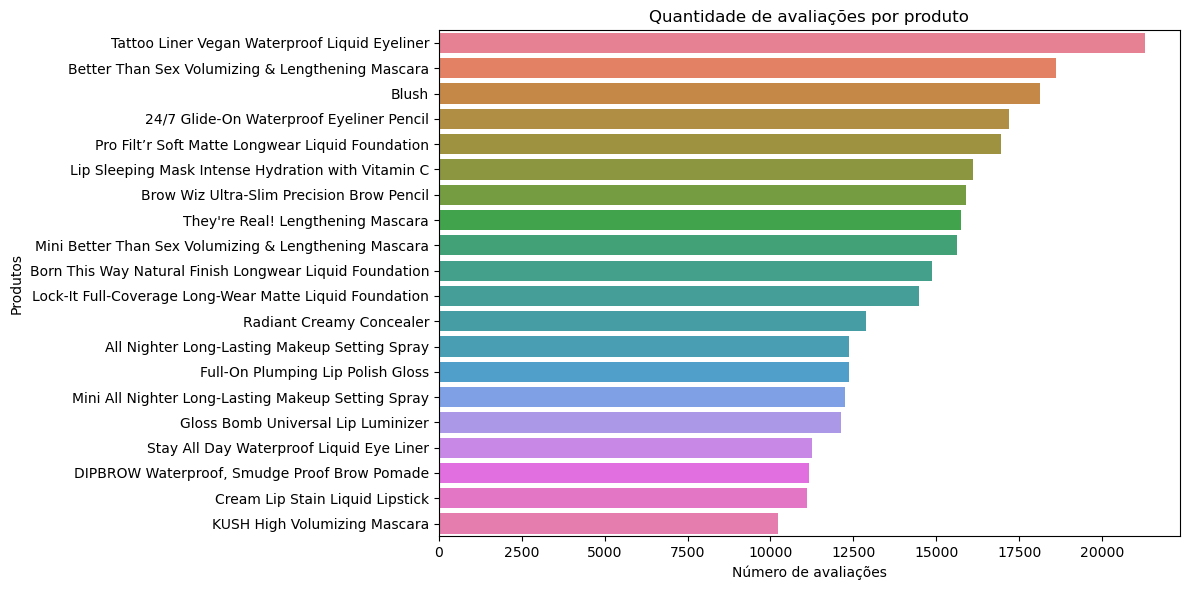

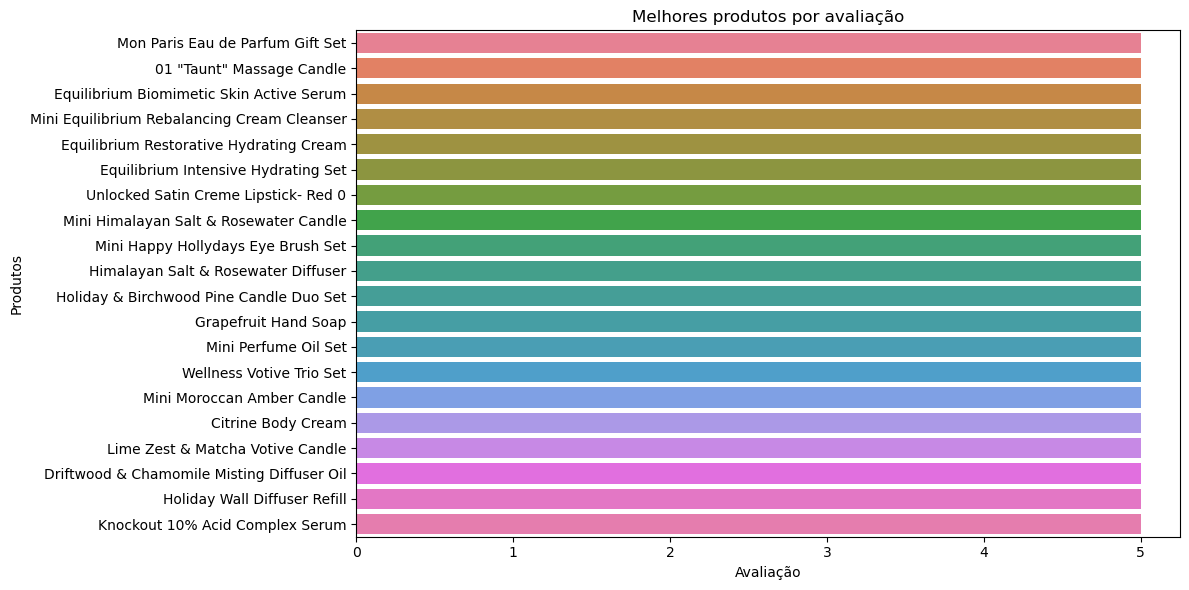

In [6]:
#--------------------Análise exploratória
# produtos mais populares por avaliações e melhores notas
most_reviews_products = df_info.sort_values(by= 'reviews', ascending=False).head(20) #refiltrar pós limpeza
plt.figure(figsize=(12, 6))
sns.barplot(data= most_reviews_products, x = 'reviews', y='product_name', hue= 'product_name', orient = 'h')
plt.title('Quantidade de avaliações por produto')
plt.xlabel('Número de avaliações')
plt.ylabel('Produtos')
plt.tight_layout()
plt.show()

top_products = df_info.sort_values(by= 'rating', ascending=False).head(20) #refiltrar pós limpeza
plt.figure(figsize=(12, 6))
sns.barplot(data= top_products, x = 'rating', y='product_name', hue= 'product_name', orient = 'h')
plt.title('Melhores produtos por avaliação')
plt.xlabel('Avaliação')
plt.ylabel('Produtos')
plt.tight_layout()
plt.show()

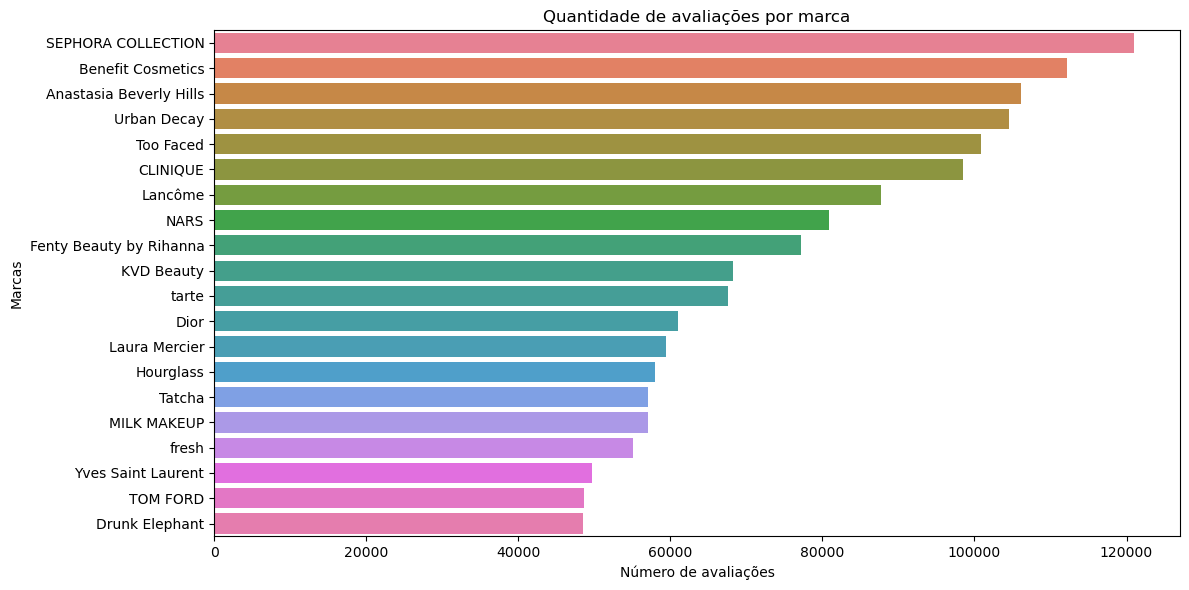

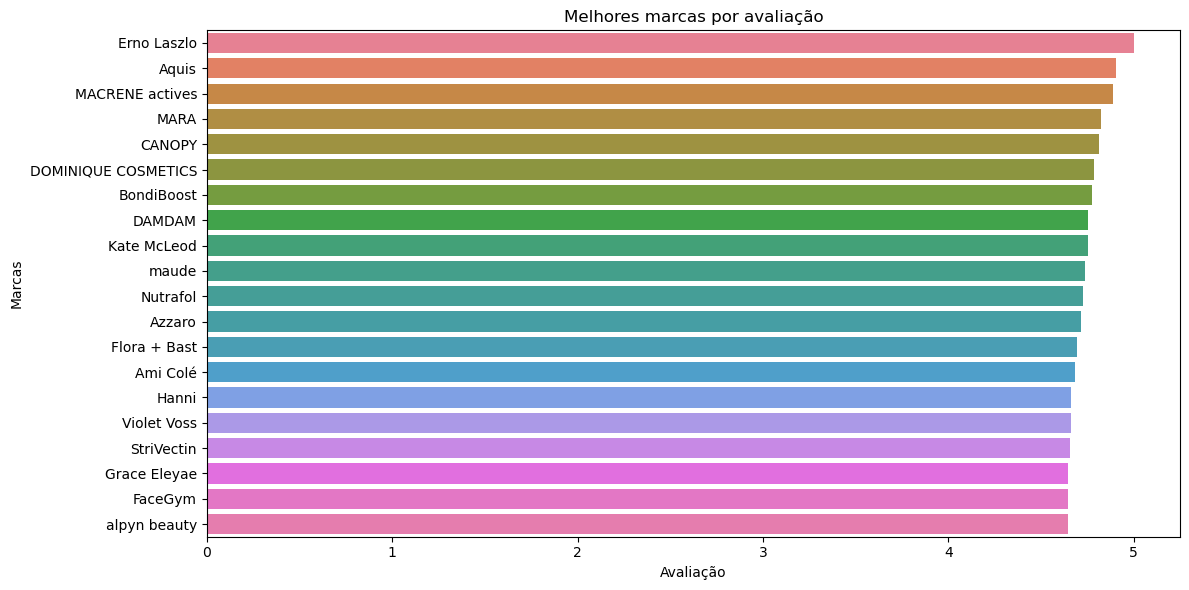

In [7]:
# quais as marcas tem mais avaliações e quais sao melhores avaliadas
most_reviews_brands = df_info.groupby(['brand_id', 'brand_name']).agg({'reviews': 'sum'}).reset_index()
most_reviews_brands = most_reviews_brands.sort_values(by= 'reviews', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data= most_reviews_brands, x = 'reviews', y='brand_name', hue='brand_name',orient = 'h', errorbar=None)
plt.title('Quantidade de avaliações por marca')
plt.xlabel('Número de avaliações')
plt.ylabel('Marcas')
plt.tight_layout()
plt.show()

top_brands = df_info.groupby(['brand_id', 'brand_name']).agg({'rating': 'mean'}).reset_index()
top_brands = top_brands.sort_values(by='rating', ascending= False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data= top_brands, x = 'rating', y='brand_name', hue='brand_name', orient = 'h')
plt.title('Melhores marcas por avaliação')
plt.xlabel('Avaliação')
plt.ylabel('Marcas')
plt.tight_layout()
plt.show()

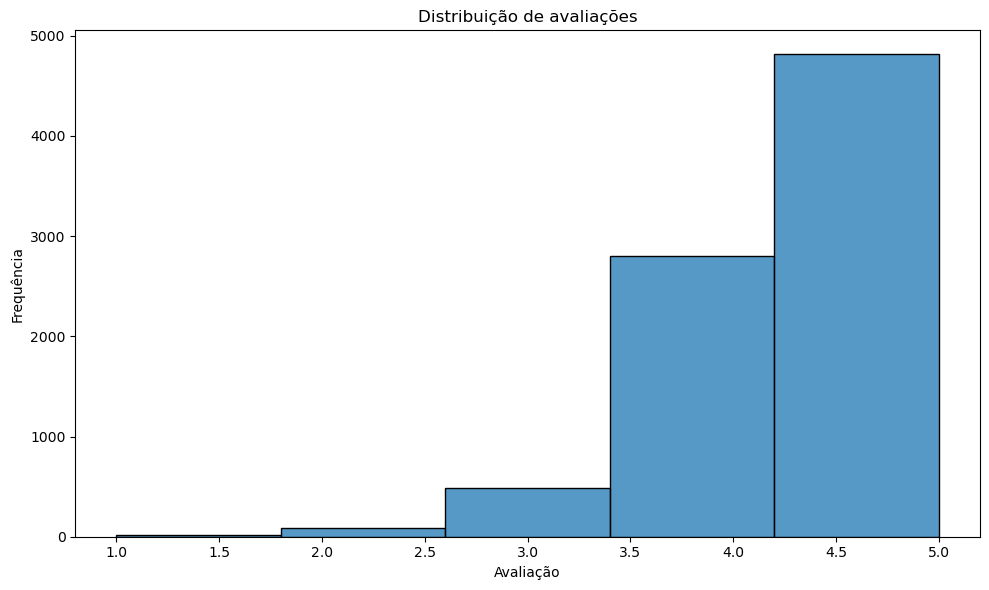

In [8]:
# distribuição de avaliações 
plt.figure(figsize=(10, 6))
sns.histplot(df_info['rating'], bins= 5)
plt.title('Distribuição de avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

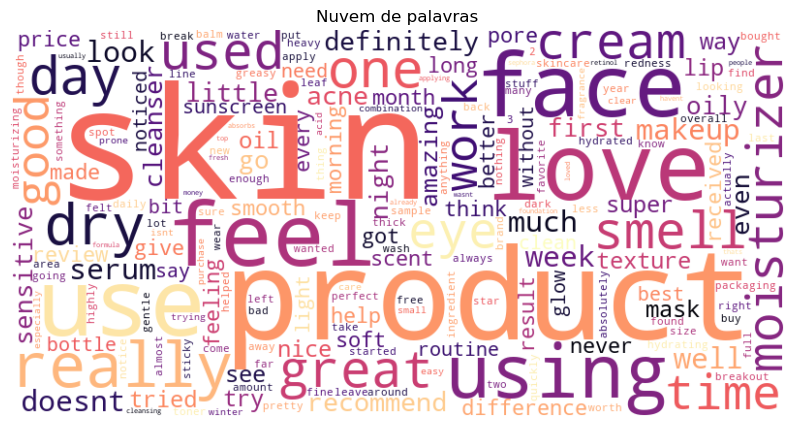

In [9]:
#nuvem de palavras
stopwords_custom = set(STOPWORDS).union(set(['im', 'ive', 'like', 'it', 'its', 'that', 'this', 'and', 'the', 'to', 'a', 'of', 'is', 'for', 'in', 'on', 'with', 'dont', 'make', 'didnt', 'cant']))

all_text = ' '.join(df_reviews1['review_text'].astype(str)) + ' ' + \
           ' '.join(df_reviews2['review_text'].astype(str)) + ' ' + \
           ' '.join(df_reviews3['review_text'].astype(str)) + ' ' + \
           ' '.join(df_reviews4['review_text'].astype(str)) + ' ' + \
           ' '.join(df_reviews5['review_text'].astype(str))
words = [word.lower() for word in all_text.split() if word.lower() not in stopwords_custom]
word_freq = Counter(words)
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white', 
                      colormap='magma',
                      stopwords=stopwords_custom)
wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de palavras')
plt.show()

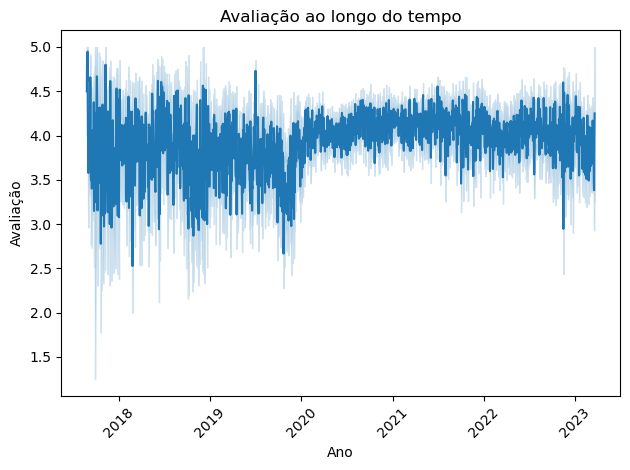

In [10]:
# analise temporal
sns.lineplot(data=df_reviews1, x='submission_time', y='rating')
plt.title('Avaliação ao longo do tempo')
plt.xlabel('Ano')
plt.ylabel('Avaliação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
#--------------------Natural Language Processing
# análise de sentimentos
def get_sentiment(df):
    sentiment = []
    scores = []
    sentiment_pipeline = pipeline('sentiment-analysis', model = 'cardiffnlp/twitter-roberta-base-sentiment')
    label_mapping = {
        'LABEL_0': 'negative',
        'LABEL_1': 'neutral',
        'LABEL_2': 'positive'
    }
    for text in tqdm(df['review_text']):
        result = sentiment_pipeline(text)
        label = result[0]['label']
        score = result[0]['score']
        mapped_label = label_mapping[label]
        sentiment.append(mapped_label)
        scores.append(score)
    df['sentiment_score'] = scores
    df['sentiment'] = sentiment
    return df
df_reviews5 = get_sentiment(df_reviews5) #apenas um df_reviews para poupar tempo


Device set to use cpu
100%|██████████| 33163/33163 [1:31:05<00:00,  6.07it/s]  


In [77]:
# verificando os sentimentos analisados
print('\nSentimentos após NLP:')
print(df_reviews5[['review_text', 'sentiment', 'sentiment_score']].head())


Sentimentos após NLP:
                                         review_text sentiment  \
0  absolutely love oil acne prone skin 30 use top...  positive   
1  gave 3 star give tiny little white head first ...   neutral   
2     work well soon wash face pat dry smell amazing  positive   
3                 oil helped hydration breakout love  positive   
4  first product review ever tell much love actua...  positive   

   sentiment_score  
0         0.750721  
1         0.840981  
2         0.958526  
3         0.842371  
4         0.462247  


In [54]:
# descobrir os temas mais comuns (utilizando df_reviews5)
def get_topics(df, text_column = 'review_text', language = 'english', min_topic_size=50, n_gram_range=(1,2), n_top_words=10):
    texts = df[text_column].astype(str).tolist()
    vectorizer_model = CountVectorizer(
        stop_words = 'english',
        ngram_range=n_gram_range
    )
    topic_model = BERTopic(
        language=language,
        min_topic_size=min_topic_size,
        vectorizer_model=vectorizer_model,
        verbose = True
    )
    topics, probs = topic_model.fit_transform(texts)

    topic_words = {}
    for topic_num in set(topics):
        if topic_num == -1:
            topic_words[topic_num] = "Outliers"
        else:
            words = topic_model.get_topic(topic_num)
            top_words = [word for word, _ in words[:n_top_words]]
            topic_words[topic_num] = ", ".join(top_words)

    df['topic'] = topics
    df['topic_text'] = [topic_words[t] for t in topics]
    return df, topic_model, topics, probs
df_reviews5, topic_model, topics, probs = get_topics(df_reviews5)

2025-05-26 20:32:22,849 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1037 [00:00<?, ?it/s]

2025-05-26 20:36:58,944 - BERTopic - Embedding - Completed ✓
2025-05-26 20:36:58,945 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-26 20:37:10,189 - BERTopic - Dimensionality - Completed ✓
2025-05-26 20:37:10,191 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-26 20:37:13,611 - BERTopic - Cluster - Completed ✓
2025-05-26 20:37:13,621 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-26 20:37:18,161 - BERTopic - Representation - Completed ✓


In [ ]:
print(df_reviews5[['author_id', 'review_text', 'topic', 'topic_text']].head())

     author_id                                        review_text  topic  \
0   1945004256  absolutely love oil acne prone skin 30 use top...      0   
1   5478482359  gave 3 star give tiny little white head first ...     -1   
2  29002209922     work well soon wash face pat dry smell amazing     -1   
3   7391078463                 oil helped hydration breakout love      1   
4   1766313888  first product review ever tell much love actua...      1   

                                          topic_text  
0  skin, moisturizer, dry, oil, cream, oily, feel...  
1                                           Outliers  
2                                           Outliers  
3  acne, spot, breakout, skin, product, dark spot...  
4  acne, spot, breakout, skin, product, dark spot...  


In [78]:
# temas que aparecem com mais frequência
topic_model.visualize_topics()

In [75]:
# quais as palavras mais comuns em cada tipo de avaliação (positiva, negativa, neutra)
def common_words_by_sentiment(df, sentiment_column='sentiment', text_column = 'review_text'):
    sentiment_groups = df.groupby(sentiment_column)[text_column].apply(lambda x: ' '.join(x)).reset_index()
    common_words ={}

    for _, row in sentiment_groups.iterrows():
        words = row[text_column].split()
        word_counts = Counter(words)
        common_words[row[sentiment_column]] = word_counts.most_common(10)
    
    return common_words

common_words_review5 = common_words_by_sentiment(df_reviews5, sentiment_column = 'sentiment', text_column='review_text')

In [150]:
for sentiment, word_list in common_words_review5.items():
    print(f'Most common words for sentiment {sentiment}:')
    for word, count in word_list:
        print(f'{word} : {count}')

Most common words for sentiment negative:
skin : 2388
product : 2210
like : 1492
face : 1074
smell : 920
didnt : 839
dont : 825
use : 816
really : 775
using : 687
Most common words for sentiment neutral:
skin : 5608
product : 3448
use : 2319
like : 2179
face : 1882
using : 1722
feel : 1296
one : 1273
dry : 1225
dont : 1202
Most common words for sentiment positive:
skin : 26966
product : 15171
love : 10827
use : 8845
feel : 7987
like : 7324
face : 7055
using : 6809
really : 6244
great : 5508


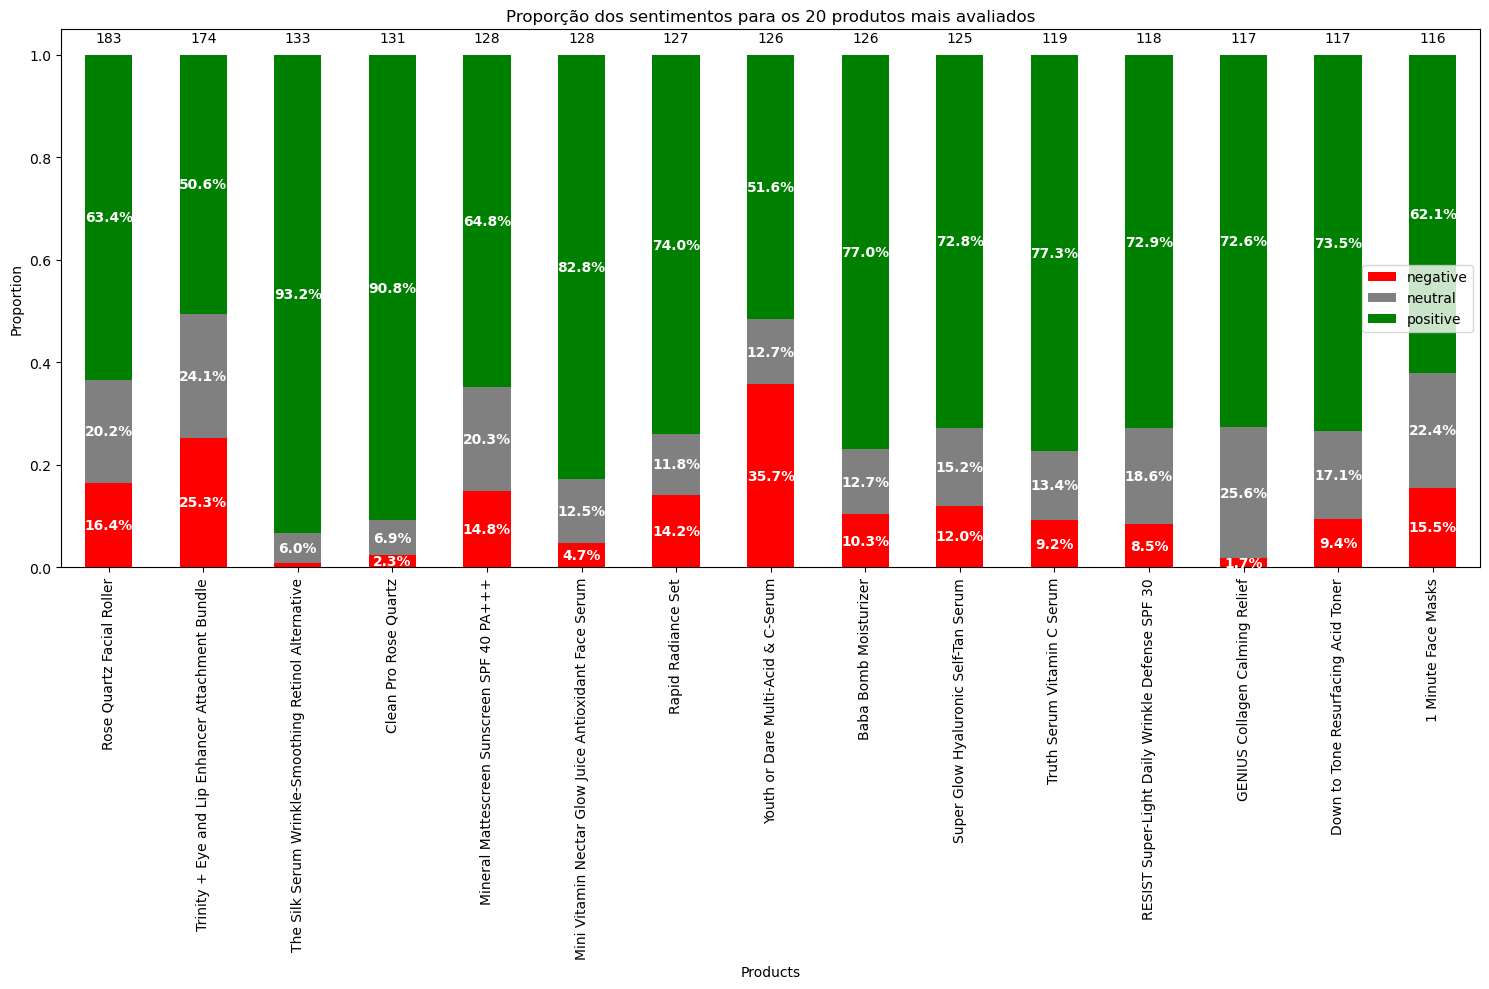

In [160]:
#--------------------Geração de insights
# sentimento geral por produto
sent_count = df_reviews5.groupby(by=['product_name','sentiment']).size().reset_index(name='count')

total_sent = sent_count.groupby(by='product_name')['count'].sum().reset_index(name='total')
sent_count = sent_count.merge(total_sent, on='product_name')
sent_count['proportion']=sent_count['count']/sent_count['total']

top_products = total_sent.sort_values(by='total', ascending=False).head(15)['product_name']

sent_df_barplot = sent_count.pivot(index='product_name', columns= 'sentiment', values='proportion')
sent_df_barplot = sent_df_barplot.merge(total_sent.set_index('product_name'), left_index=True, right_index=True, how='left')

sent_top_barplot = sent_df_barplot.loc[top_products]
sent_top_barplot = sent_top_barplot.fillna(0)

def stacked_plot(data, title):
    ax=data[['negative', 'neutral', 'positive']].plot(
        kind = 'bar',
        stacked = True,
        color = ['red', 'gray', 'green'],
        figsize = (15,10)
    )
    for idx, row in data.iterrows():
        cumulative =0
        for sentiment in ['negative', 'neutral', 'positive']:
            proportion = row[sentiment]
            if proportion >0.01:
                ax.text(
                    x = list(data.index).index(idx),
                    y = cumulative + proportion/2,
                    s = f"{proportion *100:.1f}%",
                    ha = 'center',
                    va = 'center',
                    color = 'white',
                    fontweight = 'bold'
                )
            cumulative += proportion
    for idx, total in enumerate(data['total']):
        ax.text(
            idx,
            1.02,
            str(total),
            ha = 'center',
            va = 'bottom'
        )
    plt.ylabel('Proportion')
    plt.xlabel('Products')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

stacked_plot(sent_top_barplot, 'Proporção dos sentimentos para os 20 produtos mais avaliados')

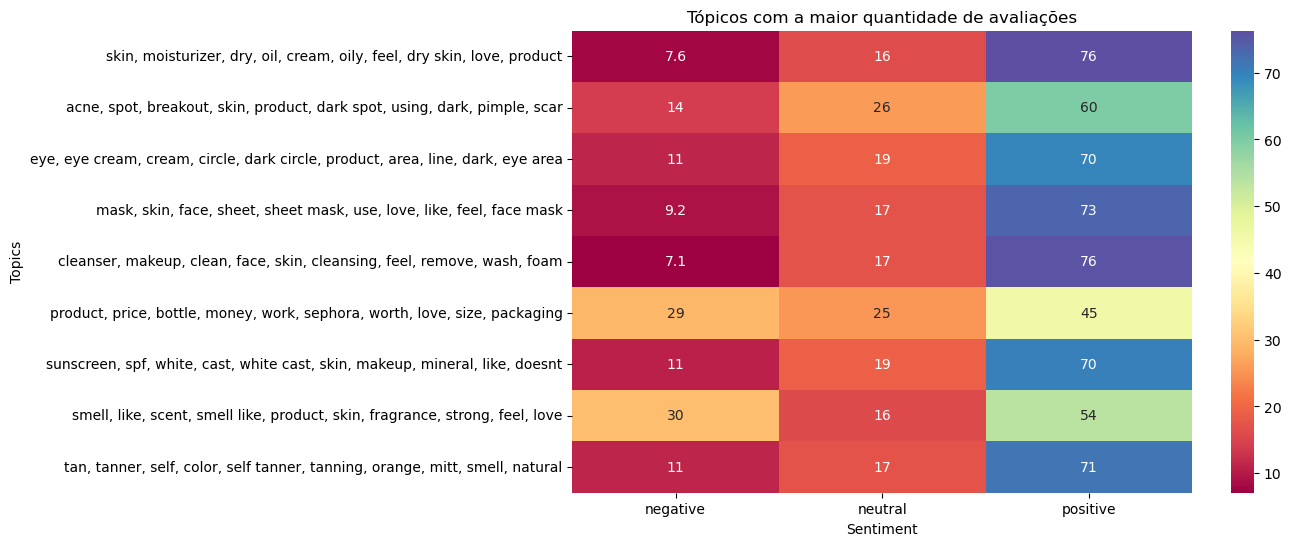

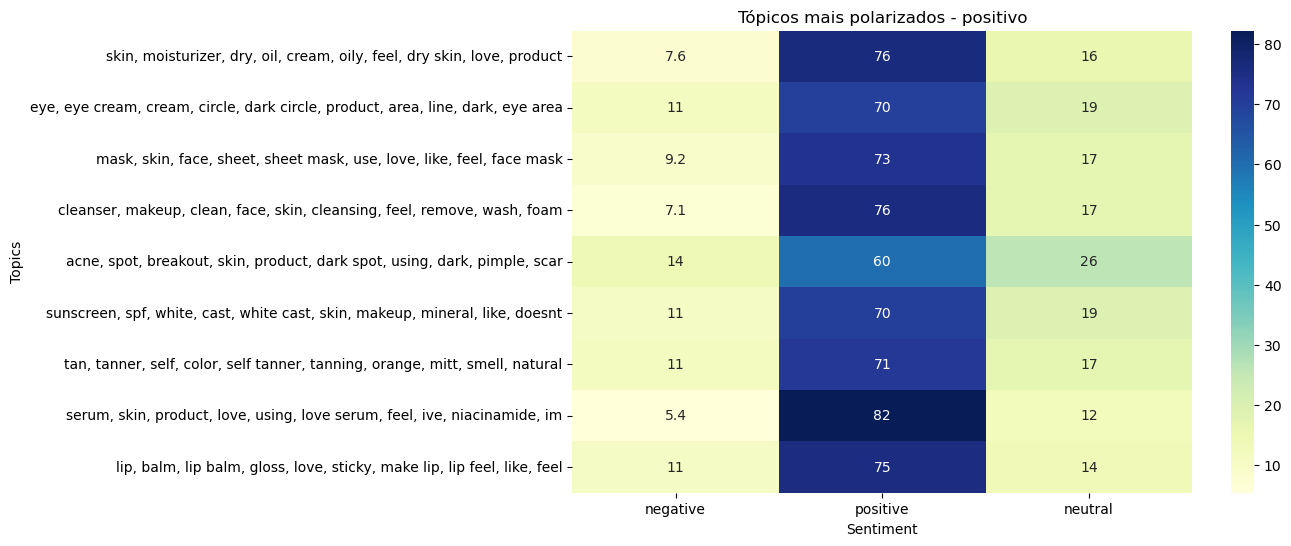

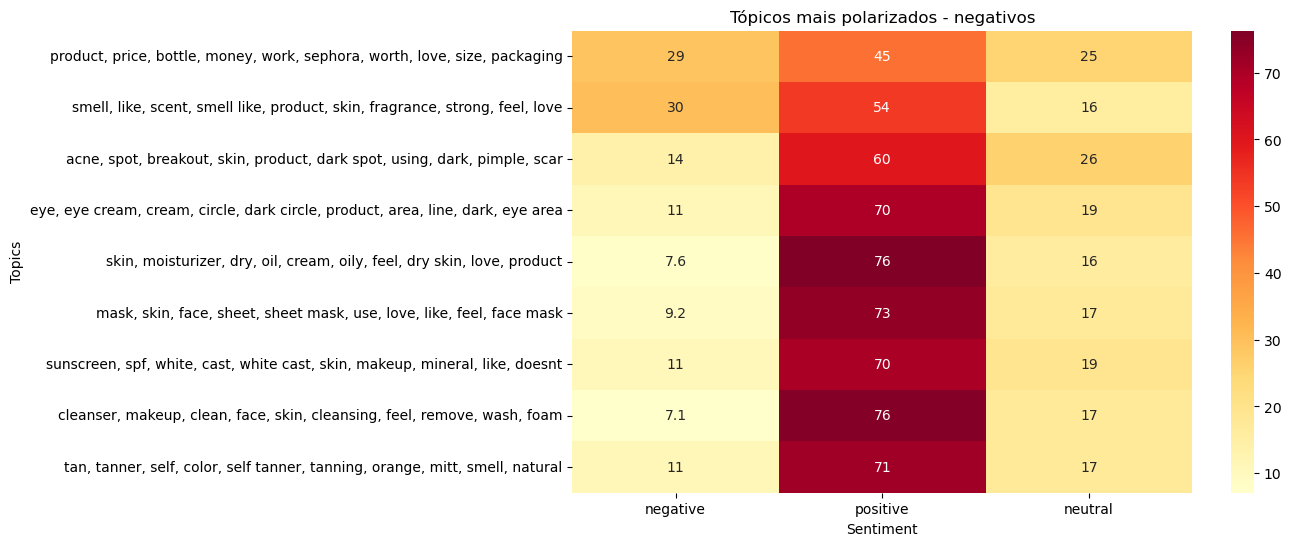

In [201]:
# identificação dos principais temas de interesse/dor
topic_sentiment = pd.crosstab(df_reviews5['topic_text'], df_reviews5['sentiment'])


#   topicos com mais avaliações
topic_counts = df_reviews5['topic_text'].value_counts()
top_topics = topic_counts.head(10).index

top_topic_sent = topic_sentiment.loc[top_topics]
top_topic_sent_percentage = top_topic_sent.div(top_topic_sent.sum(axis=1), axis=0)*100

if 'Outliers' in top_topic_sent_percentage.index:
    top_topic_sent_percentage = top_topic_sent_percentage.drop(index='Outliers', axis='index')

plt.figure(figsize=(10,6))
sns.heatmap(top_topic_sent_percentage, annot=True, cmap='spectral')
plt.xlabel('Sentiment')
plt.ylabel('Topics')
plt.title('Tópicos com a maior quantidade de avaliações')
plt.show()

#   topicos com mais polarizados (maior diferença entre avaliações positivas e negativas)
# polarização positiva
topic_sentiment['diff_pos_neg'] = abs(topic_sentiment['positive'] - topic_sentiment['negative'])
top_pol_pos_topics = topic_sentiment.sort_values(by='diff_pos_neg', ascending= False).head(10).index.tolist()

top_pol_pos_topic_sent = topic_sentiment.loc[top_pol_pos_topics, ['negative', 'positive', 'neutral']]
top_pol_pos_topic_sent_percentage = top_pol_pos_topic_sent.div(top_pol_pos_topic_sent.sum(axis=1), axis=0)*100

if 'Outliers' in top_pol_pos_topic_sent_percentage.index:
    top_pol_pos_topic_sent_percentage = top_pol_pos_topic_sent_percentage.drop(index='Outliers', axis='index')

plt.figure(figsize=(10,6))
sns.heatmap(top_pol_pos_topic_sent_percentage, annot=True, cmap='YlGnBu')
plt.xlabel('Sentiment')
plt.ylabel('Topics')
plt.title('Tópicos mais polarizados - positivo')
plt.show()

# polarização negativa
top_pol_neg_topics = topic_sentiment.sort_values(by='negative', ascending=False).head(10).index.tolist()

top_pol_neg_topic_sent = topic_sentiment.loc[top_pol_neg_topics, ['negative', 'positive', 'neutral']]
top_pol_neg_topic_sent_percentage = top_pol_neg_topic_sent.div(top_pol_neg_topic_sent.sum(axis=1), axis=0)*100

if 'Outliers' in top_pol_neg_topic_sent_percentage.index:
    top_pol_neg_topic_sent_percentage = top_pol_neg_topic_sent_percentage.drop(index='Outliers', axis= 'index')

plt.figure(figsize=(10,6))
sns.heatmap(top_pol_neg_topic_sent_percentage, annot=True, cmap='YlOrRd')
plt.xlabel('Sentiment')
plt.ylabel('Topics')
plt.title('Tópicos mais polarizados - negativos')
plt.show()